In [1]:
# IMPORTS
%reload_ext autoreload
%autoreload 2
from typing import Any

import os
import sys
import defopt
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.optimize import curve_fit
from suite2p.extraction import masks
import matplotlib
from matplotlib import cm
import warnings

import cottage_analysis as cott
from cottage_analysis.depth_analysis.filepath.generate_filepaths import *
from cottage_analysis.imaging.common import find_frames
from cottage_analysis.imaging.common import imaging_loggers_formatting as format_loggers
from cottage_analysis.stimulus_structure import sphere_structure as vis_stim_structure
from cottage_analysis.depth_analysis.plotting.plotting_utils import *
from cottage_analysis.depth_analysis.plotting.basic_vis_plots import *
from cottage_analysis.depth_analysis.depth_preprocess.process_params import *
from cottage_analysis.depth_analysis.depth_preprocess.process_trace import *

from cottage_analysis.io_module import harp

import flexiznam as flz
from pathlib import Path
from warnings import warn
from flexiznam.schema import Dataset

In [28]:
project = 'hey2_3d-vision_foodres_20220101'
mouse = 'PZAH8.2f'
session = 'S20230213'
protocols = ['SpheresPermTubeReward','SpheresPermTubeRewardPlayback']

# ----- SETUPS -----

choose_trials = 100
frame_rate = 15
speed_thr_cal = (
    0.2  # m/s, threshold for running speed when calculating depth neurons
)
is_calculate_dFF = False

for protocol in protocols:
    print(f'---------Process protocol {protocol}/{len(protocols)}---------', flush=True)
    # ----- STEP1: Generate file path -----
    flexilims_session = flz.get_flexilims_session(project_id=project)
    all_protocol_recording_entries = get_all_recording_entries(project, mouse, session, protocol=protocol, flexilims_session=flexilims_session)

    # make folder for this protocol (closedloop/playback)
    root = Path(flz.PARAMETERS["data_root"]["processed"])
    session_protocol_folder = root/project/mouse/session/protocol
    if not os.path.exists(session_protocol_folder/"plane0/"):
        os.makedirs(session_protocol_folder/"plane0/")
    session_analysis_folder = root/project/mouse/'Analysis'/session/protocol
    if not os.path.exists(session_analysis_folder/"plane0/"):
        os.makedirs(session_analysis_folder/"plane0/")
        
    all_folder_nos = []

    for irecording in range(len(all_protocol_recording_entries)):
        print(f'-----Process recording {irecording+1}/{len(all_protocol_recording_entries)}-----', flush=True)
        print("---START STEP 1---", "\n", "Getting data filepaths...", flush=True)

        (
            rawdata_folder,
            protocol_folder,
            analysis_folder,
            suite2p_folder,
            trace_folder,
        ) = generate_file_folders(
            project=project,
            mouse=mouse,
            session=session,
            protocol=protocol,
            all_protocol_recording_entries=all_protocol_recording_entries, 
            recording_no=irecording, 
            flexilims_session=flexilims_session
        )
        if not os.path.exists(analysis_folder/"plane0/"):
            os.makedirs(analysis_folder/"plane0/")

        if "Playback" in protocol:
            (
                rawdata_folder_closeloop,
                protocol_folder_closeloop,
                analysis_folder_closeloop,
                suite2p_folder_closeloop,
                trace_folder_closeloop,
            ) = generate_file_folders(
                project=project,
                mouse=mouse,
                session=session,
                protocol=protocol.replace("Playback", ""),
                all_protocol_recording_entries=all_protocol_recording_entries, 
                recording_no=irecording, 
                flexilims_session=flexilims_session
            )
            assert os.path.exists(analysis_folder_closeloop/"plane0/")
            
        # Indicate the folder no for suite2p trace to find the frame number of this folder
        sess_children = get_session_children(project=project, mouse=mouse, session=session, flexilims_session=flexilims_session)
        sess_children_protocols = sess_children[sess_children['name'].str.contains('(SpheresPermTubeReward|Fourier|Retinotopy)')]
        folder_no = sess_children_protocols.index.get_loc(sess_children_protocols[sess_children_protocols.id == all_protocol_recording_entries.iloc[irecording].id].index[0])
        all_folder_nos.append(folder_no)
        print("---STEP 1 FINISHED.---", "\n", flush=True)

        # -----STEP2: Calculate dF/F from the raw fluorescence trace and Save -----
        print("---START STEP 2---", "\n", "Calculating dF/F for all ROIs...", flush=True)
        # Load suite2p files
        stat = np.load(suite2p_folder/"stat.npy", allow_pickle=True)
        ops = np.load(suite2p_folder/"ops.npy", allow_pickle=True)
        ops = ops.item()
        stats = np.load(suite2p_folder/"stat.npy", allow_pickle=True)
        iscell = np.load(suite2p_folder/"iscell.npy", allow_pickle=True)[:, 0]
        # F = np.load(trace_folder + 'F.npy', allow_pickle=True)
        Fast = np.load(trace_folder/"Fast.npy", allow_pickle=True)
        # Fneu = np.load(trace_folder + 'Fneu.npy', allow_pickle=True)
        # spks = np.load(trace_folder + 'spks.npy', allow_pickle=True)

        # The ROI no. for all cells (excluding non-cells)
        which_rois = (np.arange(Fast.shape[0]))[iscell.astype("bool")]

        # Calculate dF/F
        if is_calculate_dFF:
            dffs_ast = calculate_dFF(
                f=Fast, mode="gmm", n_components=2, verbose=True
            )
            np.save(trace_folder/"dffs_ast.npy", dffs_ast)
            print("dFFs saved.", flush=True)
            visualize_dffs = True
            if visualize_dffs:
                plt.figure(figsize=(10, 5))
                plt.plot(dffs_ast[0])
                plt.savefig(trace_folder/"dffs_ast_example.png")
        
        dffs_ast = np.load(trace_folder/"dffs_ast.npy")
        print("---STEP 2 FINISHED.---", "\n", flush=True)
        
        # -----STEP3: Align timestamps of visual stimulation loggers and save as img_VS.pickle file-----
        # This is trial-based analysis and has not included screen frame no.
        print("---START STEP 3---", "\n", "Align timestamps for all loggers...", flush=True)
        # photodiode_file = generate_filepaths.generate_logger_path(project=project,
        #                                                           mouse=mouse,
        #                                                           session=session,
        #                                                           protocol=protocol,
        #                                                           rawdata_root=rawdata_root,
        #                                                           root=root,
        #                                                           logger_name='PhotodiodeLog')

        # VS_photodiode_logger = format_loggers.format_VS_photodiode_logger(photodiode_file)
        # # plt.plot(VS_photodiode_logger['Photodiode'][100000:110000])
        # if not os.path.exists(trace_folder+'checker_plots/'):
        #     os.makedirs(trace_folder+'checker_plots/')
        # VS_photodiode_logger = find_frames.find_VS_frames(photodiode_df=VS_photodiode_logger, frame_rate=144, upper_thr=70,
        #                                                   lower_thr=30, plot=True, plot_start=100000, plot_range=2000,
        #                                                   plot_dir=trace_folder+'checker_plots/')
        # print('Photodiode signal extracted.', flush=True)

        # Load vis-stim param logger
        VS_param_file = generate_logger_path(
            project=project,
            mouse=mouse,
            session=session,
            protocol=protocol,
            logger_name="NewParams",    
            all_protocol_recording_entries=all_protocol_recording_entries, 
            recording_no=irecording, 
            flexilims_session=flexilims_session,
        )
        VS_param_logger = format_loggers.format_VS_param_logger(
            VS_param_file, which_protocol=protocol
        )

        # Load frame trigger logger and find frame triggers
        harpmessage_file = generate_logger_path(
            project=project,
            mouse=mouse,
            session=session,
            protocol=protocol,
            all_protocol_recording_entries=all_protocol_recording_entries, 
            recording_no=irecording, 
            flexilims_session=flexilims_session,
            logger_name="harp_message",
        )
        msg = Path(str(harpmessage_file).replace('csv','bin'))
        p_msg = trace_folder
        p_msg = p_msg / (msg.stem + '.npz')
        if p_msg.is_file():
            harp_messages = np.load(p_msg)
        else:
            print('Saving harp messages into npz...', flush=True)
            harp_messages = harp.load_harp(msg)
            p_msg.parent.mkdir(parents=True, exist_ok=True)
            np.savez(p_msg, **harp_messages)
            print('Harp messages saved.', flush=True)

        img_frame_logger = format_loggers.format_img_frame_logger(
            harp_messages, register_address=32
        )
        frame_number = ops["frames_per_folder"][folder_no]
        img_frame_logger = find_frames.find_imaging_frames(
            harp_message=img_frame_logger,
            frame_number=frame_number,
            exposure_time=0.0324 * 2,
            register_address=32,
            exposure_time_tolerance=0.001,
        )
        print("Frame trigger extracted.", flush=True)
        
        
        # Align vis-stim param timestamps
        # img_VS = align_timestamps.align_timestamps(VS_frames=VS_photodiode_logger, VS_params=VS_param_logger,
        #                                            imaging_frames=img_frame_logger)
        img_VS = pd.merge_asof(
            img_frame_logger,
            VS_param_logger,
            on="HarpTime",
            allow_exact_matches=True,
            direction="backward",
        )

        # Add running logger to the aligned dataframe (ALL DISTANCE IN METERS)
        rotary_encoder_file = generate_logger_path(
            project=project,
            mouse=mouse,
            session=session,
            protocol=protocol,
            all_protocol_recording_entries=all_protocol_recording_entries, 
            recording_no=irecording, 
            flexilims_session=flexilims_session,
            logger_name="RotaryEncoder",
        )
        mousez_logger = pd.read_csv(
            rotary_encoder_file, sep=",", usecols=["HarpTime", "EyeZ", "MouseZ"]
        )
        img_VS = pd.merge_asof(
            img_VS,
            mousez_logger,
            on="HarpTime",
            allow_exact_matches=True,
            direction="backward",
        )

        img_VS.EyeZ = img_VS.EyeZ / 100  # Convert cm to m
        img_VS.MouseZ = img_VS.MouseZ / 100  # Convert cm to m
        img_VS.Depth = img_VS.Depth / 100  # Convert cm to m
        img_VS.Z0 = img_VS.Z0 / 100  # Convert cm to m

        depth_list = img_VS["Depth"].unique()
        depth_list = np.round(depth_list, 2)
        depth_list = depth_list[~np.isnan(depth_list)].tolist()
        depth_list.remove(-99.99)
        depth_list.sort()

        # print(img_VS[:20], flush=True)
        # Save img_VS
        with open(protocol_folder/"img_VS.pickle", "wb") as handle:
            pickle.dump(img_VS, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("Timestamps aligned and saved.", flush=True)
        print("---STEP 3 FINISHED.---", "\n", flush=True)
        
        # -----STEP4: Get the visual stimulation structure and Save (find the imaging frames for visual stimulation)-----
        print("---START STEP 4---", "\n", "Get vis-stim structure...", flush=True)
        with open(protocol_folder/"img_VS.pickle", "rb") as handle:
            img_VS = pickle.load(handle)
        stim_dict = vis_stim_structure.create_stim_dict(
            depth_list=depth_list, img_VS=img_VS, choose_trials=None
        )
        # Trim stim_dict before appending     
        min_trial_num = find_min_trial_num_all_depths(stim_dict=stim_dict, depth_list=depth_list, isStim=True)
        stim_dict = vis_stim_structure.create_stim_dict(
            depth_list=depth_list, img_VS=img_VS, choose_trials=min_trial_num 
        )
        with open(protocol_folder/"stim_dict.pickle", "wb") as handle:
            pickle.dump(stim_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

            
        # Append all img_VS, stim_dict and dffs_ast together of all recordings
        if irecording == 0:
            img_VS_all = img_VS.copy()
            stim_dict_all = stim_dict.copy()
            dffs_all = dffs_ast.copy()
            previous_frame_num = 0
        else:
            with open(session_protocol_folder/"plane0/img_VS_all.pickle", "rb") as handle:
                img_VS_all = pickle.load(handle)
            with open(session_protocol_folder/"plane0/stim_dict_all.pickle", "rb") as handle:
                stim_dict_all = pickle.load(handle)
            dffs_all = np.load(session_protocol_folder/"plane0/dffs_ast_all.npy")
                
            previous_frame_num = len(img_VS_all)
        
            img_VS.ImagingFrame = img_VS.ImagingFrame+previous_frame_num
            img_VS_all = img_VS_all.append(img_VS, ignore_index=True)
            
            stim_dict_append = {}
            for key in stim_dict.keys():
                stim_dict_append[key] = {}
                stim_dict_append[key]['start'] = stim_dict[key]['start'] + previous_frame_num
                stim_dict_append[key]['stop'] = stim_dict[key]['stop'] + previous_frame_num
                stim_dict_all[key]['start'] = np.append(stim_dict_all[key]['start'],stim_dict_append[key]['start'])
                stim_dict_all[key]['stop'] = np.append(stim_dict_all[key]['stop'],stim_dict_append[key]['stop'])
            stim_dict_all['stim_all']['depth'] =  np.append(stim_dict_all['stim_all']['depth'], stim_dict['stim_all']['depth'])
            
            dffs_all = np.append(dffs_all, dffs_ast, axis=1)
        
        with open(session_protocol_folder/"plane0/img_VS_all.pickle", "wb") as handle:
            pickle.dump(img_VS_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
        with open(session_protocol_folder/"plane0/stim_dict_all.pickle", "wb") as handle:
            pickle.dump(stim_dict_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        np.save(session_protocol_folder/"plane0/dffs_ast_all.npy",dffs_all)
        print("---STEP 4 FINISHED.---", "\n", flush=True)
    print("---All recordings concatenated and saved.---", "\n", flush=True)
        

            
    

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---------Process protocol SpheresPermTubeReward/2---------
-----Process recording 1/3-----
---START STEP 1--- 
 Getting data filepaths...
---STEP 1 FINISHED.--- 

---START STEP 2--- 
 Calculating dF/F for all ROIs...


<ipython-input-28-f6cc4a02c2c4>:74: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  sess_children_protocols = sess_children[sess_children['name'].str.contains('(SpheresPermTubeReward|Fourier|Retinotopy)')]


---STEP 2 FINISHED.--- 

---START STEP 3--- 
 Align timestamps for all loggers...
ImagingFrames in video: 30788
ImagingFrame triggers: 30789
ImagingFrames in video: 30788
ImagingFrame triggers: 30788
Frame trigger extracted.


/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Timestamps aligned and saved.
---STEP 3 FINISHED.--- 

---START STEP 4--- 
 Get vis-stim structure...


/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


---STEP 4 FINISHED.--- 

-----Process recording 2/3-----
---START STEP 1--- 
 Getting data filepaths...
---STEP 1 FINISHED.--- 

---START STEP 2--- 
 Calculating dF/F for all ROIs...
---STEP 2 FINISHED.--- 

---START STEP 3--- 
 Align timestamps for all loggers...
ImagingFrames in video: 76482
ImagingFrame triggers: 76483
ImagingFrames in video: 76482
ImagingFrame triggers: 76482
Frame trigger extracted.
Timestamps aligned and saved.
---STEP 3 FINISHED.--- 

---START STEP 4--- 
 Get vis-stim structure...
---STEP 4 FINISHED.--- 

-----Process recording 3/3-----
---START STEP 1--- 
 Getting data filepaths...
---STEP 1 FINISHED.--- 

---START STEP 2--- 
 Calculating dF/F for all ROIs...
---STEP 2 FINISHED.--- 

---START STEP 3--- 
 Align timestamps for all loggers...
Frame trigger extracted.
Timestamps aligned and saved.
---STEP 3 FINISHED.--- 

---START STEP 4--- 
 Get vis-stim structure...
---STEP 4 FINISHED.--- 

---All recordings concatenated and saved.--- 

---------Process protocol 

In [66]:
trace_folder = Path("/camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_foodres_20220101/PZAH8.2f/S20230213/R135957_SpheresPermTubeReward/SpheresPermTubeReward_suite2p_traces_0/")
p_msg = trace_folder/"harpmessage.npz"
if p_msg.is_file():
    harp_messages = np.load(p_msg)
    
harp_messages_frametriggers = pd.DataFrame(columns=['Timestamp','FrameTriggers'])
harp_messages_frametriggers['Timestamp'] = harp_messages['digital_time']
harp_messages_frametriggers['FrameTriggers'] = harp_messages['lick_detection']
harp_messages_frametriggers['RegisterAddress']=32

img_frame_logger = find_frames.find_imaging_frames(
    harp_message=harp_messages_frametriggers,
    frame_number=30788,
    exposure_time=0.0324 * 2,
    register_address=32,
    exposure_time_tolerance=0.001,
)
img_frame_logger

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ERROR: FRAME NUMBER NOT CORRECT!!!


/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,HarpTime,FrameTriggers,ImagingFrame
3,2.091866e+06,0,0
5,2.091866e+06,0,1
7,2.091866e+06,0,2
9,2.091867e+06,0,3
11,2.091867e+06,0,4
...,...,...,...
157913,2.096898e+06,0,73021
157915,2.096898e+06,0,73022
157917,2.096898e+06,0,73023
157919,2.096898e+06,0,73024


In [31]:
harp_messages['digital_time'][-1], img_frame_logger_csv['HarpTime'].iloc[-1]

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2091826.843424, 2091826.7714)

In [37]:
0.324*2

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.648

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


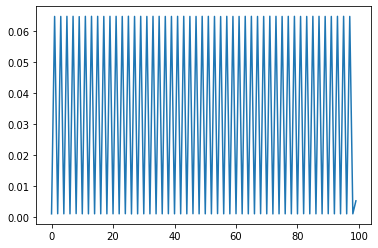

In [40]:
plt.plot(np.diff(harp_messages['digital_time'])[2:][-100:])

In [56]:
harptime_diff = np.diff(harp_messages['digital_time'])
frame_diff = np.diff(np.where(harptime_diff>0.06)[0])
np.where(frame_diff>2)

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([  907,   908,   909,   910,   911,   912,   913,   914,   915,
          917,   918,  1442,  1444,  1445,  1446,  1447,  1448,  1449,
         1450,  1451,  1596,  1601,  1688,  1705,  1714,  1727,  1728,
         1729,  1731,  1732,  1734,  1735,  1736,  1737,  1738,  1739,
         1740,  1742,  1744,  1745,  1746,  1747,  1755,  1757,  1763,
         1766,  1771,  1774,  1775,  1781,  1783,  1785,  1791,  1794,
         1796,  1799,  1806,  1814,  1825,  1826,  1874,  1879,  1881,
         1886,  1914,  1953,  1962,  1964,  2031,  2183,  2190,  2447,
         2448,  2450,  2451,  2457,  2460,  2550,  2552,  2553,  2555,
         2609,  2619,  2620,  2621,  2642,  2643,  2644,  2645,  2646,
         2719,  2723,  2728,  2732,  2741,  2744,  2752,  2753,  2903,
         2907,  2909,  2910,  2918,  2920,  2926,  2943,  2947,  2969,
         2979,  3007,  3272,  3274,  3275,  3284,  3285,  3287,  3288,
         3290,  3293,  3296,  3357,  3358,  3373,  3639,  3643,  3648,
      

In [ ]:
plt.plot(harptime_diff)

In [62]:
len(frame_diff)

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


29494

In [61]:
frame_diff[904:930]

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 2,  2,  2,  6,  8,  6,  6,  6, 18,  6,  6,  6,  2,  6,  6,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2])

In [57]:
harptime_diff[907:920]

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.001024, 0.064768, 0.001024, 0.064768, 0.001024, 0.064736,
       0.001024, 0.064736, 0.001024, 0.064768, 0.001024, 0.064736,
       0.001056])

In [52]:
np.diff(harp_messages['digital_time'])[:50]

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.006752, 0.41056 , 0.064736, 0.001056, 0.064736, 0.001024,
       0.064736, 0.001056, 0.064736, 0.001024, 0.064736, 0.001056,
       0.064736, 0.001024, 0.064768, 0.001024, 0.064736, 0.001024,
       0.064736, 0.001056, 0.064736, 0.001024, 0.064768, 0.001024,
       0.064736, 0.001024, 0.064736, 0.001056, 0.064736, 0.001024,
       0.064736, 0.001056, 0.064768, 0.001024, 0.064704, 0.001056,
       0.064736, 0.001024, 0.064736, 0.001056, 0.064736, 0.001024,
       0.064736, 0.001056, 0.064736, 0.001024, 0.064736, 0.001056,
       0.064736, 0.001024])

In [65]:
harp_messages_frame_csv= format_loggers.format_img_frame_logger(
    '/camp/lab/znamenskiyp/data/instruments/raw_data/projects/hey2_3d-vision_foodres_20220101/PZAH8.2f/S20230213/R135957_SpheresPermTubeReward/harpmessage.csv', register_address=32
        )
img_frame_logger_csv = find_frames.find_imaging_frames(
    harp_message=harp_messages_frame_csv,
    frame_number=30788,
    exposure_time=0.0324 * 2,
    register_address=32,
    exposure_time_tolerance=0.001,
)
img_frame_logger_csv

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ERROR: FRAME NUMBER NOT CORRECT!!!


/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,HarpTime,DataElement0,Port0,Port1,Port2,Port3,Port4,Port5,Port6,Port7,ImagingFrame
8552,2.091866e+06,4,0,0,1,0,0,0,0,0,0
8620,2.091866e+06,4,0,0,1,0,0,0,0,0,1
8688,2.091866e+06,4,0,0,1,0,0,0,0,0,2
8756,2.091867e+06,4,0,0,1,0,0,0,0,0,3
8823,2.091867e+06,4,0,0,1,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...
5198016,2.096898e+06,4,0,0,1,0,0,0,0,0,76478
5198084,2.096898e+06,4,0,0,1,0,0,0,0,0,76479
5198152,2.096898e+06,4,0,0,1,0,0,0,0,0,76480
5198220,2.096898e+06,4,0,0,1,0,0,0,0,0,76481


In [44]:
len(harp_messages_frame_csv.HarpTime.diff()), len(np.diff(harp_messages['digital_time']))

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(61583, 63677)

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


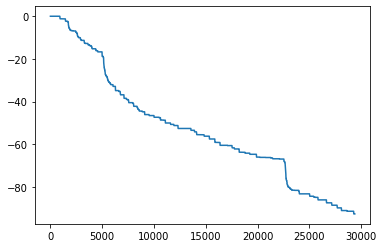

In [25]:
plt.plot(np.array(img_frame_logger_csv['HarpTime'][:len(img_frame_logger['HarpTime'])]) - np.array(img_frame_logger['HarpTime']))

In [6]:
harp_messages_frametriggers = pd.DataFrame(columns=['Timestamp','FrameTriggers'])
harp_messages_frametriggers['Timestamp'] = harp_messages['digital_time']
harp_messages_frametriggers['FrameTriggers'] = harp_messages['lick_detection']
harp_messages_frametriggers['RegisterAddress']=32

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
len(harp_messages['digital_time'])

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


63678

In [13]:
img_frame_logger = find_frames.find_imaging_frames(
    harp_message=harp_messages_frametriggers,
    frame_number=30788,
    exposure_time=0.0324 * 2,
    register_address=32,
    exposure_time_tolerance=0.001,
)
img_frame_logger

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ERROR: FRAME NUMBER NOT CORRECT!!!


,HarpTime,FrameTriggers,ImagingFrame
3,2.089802e+06,0,0
5,2.089802e+06,0,1
7,2.089802e+06,0,2
9,2.089802e+06,0,3
11,2.089802e+06,0,4
...,...,...,...
63667,2.091827e+06,0,29375
63669,2.091827e+06,0,29376
63671,2.091827e+06,0,29377
63673,2.091827e+06,0,29378


In [11]:
dffs_ast = np.load(trace_folder/'dffs_ast.npy')
dffs_ast.shape

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4985, 30788)

In [8]:
img_frame_logger

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HarpTime,FrameTriggers,ImagingFrame
3,2.089802e+06,0,0
5,2.089802e+06,0,1
7,2.089802e+06,0,2
9,2.089802e+06,0,3
11,2.089802e+06,0,4
...,...,...,...
63667,2.091827e+06,0,29375
63669,2.091827e+06,0,29376
63671,2.091827e+06,0,29377
63673,2.091827e+06,0,29378


In [91]:
# -----STEP5: Find depth neurons, save and Plot depth neuron spatial distribution-----
# Depth neurons are calculated only based on the time where running speed exceeds a certain threshold (default 0.2 m/s)
print("---START STEP 5---", "\n", "Find depth neurons...", flush=True)
protocol = protocols[0]
session_protocol_folder = root/project/mouse/session/protocol
session_analysis_folder = root/project/mouse/'Analysis'/session/protocol
if not os.path.exists(session_analysis_folder/'plane0/'):
    os.makedirs(session_analysis_folder/'plane0/')
assert('Playback' not in protocol)
# Create an array for running speed (ndepth x ntrials x time)
with open(session_protocol_folder/"plane0/img_VS_all.pickle", "rb") as handle:
    img_VS_all = pickle.load(handle)
with open(session_protocol_folder/"plane0/stim_dict_all.pickle", "rb") as handle:
    stim_dict_all = pickle.load(handle)
dffs_ast_all = np.load(session_protocol_folder/"plane0/dffs_ast_all.npy")
        
speeds = img_VS_all.MouseZ.diff() / img_VS_all.HarpTime.diff()  # m/s
speeds[0] = 0
# speed_thr = 0.01
# speeds_thred = thr(speeds, speed_thr)
speed_arr, _ = create_speed_arr(
    speeds=speeds,
    depth_list=depth_list,
    stim_dict=stim_dict_all,
    mode="sort_by_depth",
    protocol="fix_length",
    blank_period=0,
    frame_rate=frame_rate,
)

# For each CELL (not all ROIs), create an array for dFF trace.
# Average across time for each trial, and then do an anova for all depths with all trial average as data points.
anova_ps = []
for roi in which_rois:
    trace_arr, _ = create_trace_arr_per_roi(
        which_roi=roi,
        dffs=dffs_ast_all,
        depth_list=depth_list,
        stim_dict=stim_dict_all,
        mode="sort_by_depth",
        protocol="fix_length",
        blank_period=0,
        frame_rate=frame_rate,
    )
    (ndepths, ntrials, nframes) = trace_arr.shape
    trace_arr[speed_arr < speed_thr_cal] = np.nan
    trace_arr_mean_eachtrial = np.nanmean(trace_arr, axis=2)
    groups = np.split(trace_arr_mean_eachtrial.reshape(len(depth_list),-1),len(depth_list))
    groups = [x.ravel().tolist() for x in groups]
    _, p = scipy.stats.f_oneway(*groups)
    anova_ps.append(p)
anova_ps = np.array(anova_ps)

# # Gaussian fit for depth selectivity
# from scipy.optimize import curve_fit
# def gaussian_func(x, a, x0, sigma):
#     return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

depth_neurons = which_rois[
    np.where(anova_ps < 0.05)[0]]

np.save(session_analysis_folder/"plane0/anova_p.npy", anova_ps)
np.save(session_analysis_folder/"plane0/depth_neurons.npy", depth_neurons)

max_depths = (
    np.ones(len(depth_neurons)) * 9999
)  # index no. from depth_list indicating the max depth of each depth neuron
max_depths_values = (
    np.ones(len(depth_neurons)) * 9999
)  # depth value = the max depth of each depth neuron

# for iroi in range(len(depth_neurons)):
for iroi in [2]:
    roi = depth_neurons[iroi]
    trace_arr, _ = create_trace_arr_per_roi(
        roi,
        dffs_ast_all,
        depth_list,
        stim_dict,
        mode="sort_by_depth",
        protocol="fix_length",
        blank_period=0,
        frame_rate=15,
    )
    trace_arr_mean_eachtrial = np.nanmean(trace_arr, axis=2)
    trace_arr_depth_mean = np.nanmean(trace_arr_mean_eachtrial, axis=1)
    max_depth = np.where(trace_arr_depth_mean == np.max(trace_arr_depth_mean))[0]
    max_depths[iroi] = max_depth
    max_depths_values[iroi] = depth_list[max_depth[0]]
    print(max_depth)

max_depths[max_depths == 9999] = np.nan
np.save(session_analysis_folder/"plane0/max_depths_index.npy", max_depths)
np.save(session_analysis_folder/"plane0/max_depths_values.npy", max_depths_values)
print("Depth neurons and max depths saved.", flush=True)

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---START STEP 5--- 
 Find depth neurons...
[5]
Depth neurons and max depths saved.


In [71]:
MIN_SIGMA=0.5

def gaussian_func(x, a, x0, log_sigma,b):
    a = a
    sigma = np.exp(log_sigma)+MIN_SIGMA
    return (a * np.exp(-(x - x0) ** 2) / (2 * sigma ** 2))+b
protocol = protocols[0]
session_analysis_folder_original = root/project/mouse/'Analysis'/session/protocol
# Fit depth tuning curve
for protocol in protocols:
    print(f'---------Fit gaussian depth tuning for protocol {protocol}/{len(protocols)}---------', flush=True)
    # ----- STEP1: Generate file path -----
    flexilims_session = flz.get_flexilims_session(project_id=project)
    all_protocol_recording_entries = get_all_recording_entries(project, mouse, session, protocol=protocol, flexilims_session=flexilims_session)

    # make folder for this protocol (closedloop/playback)
    root = Path(flz.PARAMETERS["data_root"]["processed"])
    session_protocol_folder = root/project/mouse/session/protocol
    session_analysis_folder = root/project/mouse/'Analysis'/session/protocol
        
    with open(session_protocol_folder/"plane0/img_VS_all.pickle", "rb") as handle:
        img_VS_all = pickle.load(handle)
    with open(session_protocol_folder/"plane0/stim_dict_all.pickle", "rb") as handle:
        stim_dict_all = pickle.load(handle)
    dffs_ast_all = np.load(session_protocol_folder/"plane0/dffs_ast_all.npy")
    
    depth_neuron = np.load(session_analysis_folder_original/"plane0/depth_neurons.npy")
    max_depths_index = np.load(session_analysis_folder/"plane0/max_depths_index.npy")
        
    print('---START STEP 6---', '\n', 'Fit gaussian depth tuning...', flush=True)
    print('MIN SIGMA', str(MIN_SIGMA), flush=True)
    batch_num = 1
    depth_min = 2
    depth_max = 2000
    gaussian_depth_fit_df = pd.DataFrame(columns=['ROI', 'a', 'x0_logged', 'log_sigma', 'b', 'preferred_depth_idx','r_sq'])
    gaussian_depth_fit_df.ROI = depth_neurons
    gaussian_depth_fit_df.preferred_depth_idx = max_depths_index
    speeds = img_VS_all.MouseZ.diff() / img_VS_all.HarpTime.diff()  # m/s
    speeds[0] = 0
    # speed_thr = 0.01
    # speeds_thred = thr(speeds, speed_thr)
    speed_arr, _ = create_speed_arr(
        speeds=speeds,
        depth_list=depth_list,
        stim_dict=stim_dict_all,
        mode="sort_by_depth",
        protocol="fix_length",
        blank_period=0,
        frame_rate=frame_rate,
    )

    for iroi, choose_roi in enumerate(depth_neurons):
        roi = choose_roi
        trace_arr, _ = create_trace_arr_per_roi(
            which_roi=roi,
            dffs=dffs_ast_all,
            depth_list=depth_list,
            stim_dict=stim_dict_all,
            mode="sort_by_depth",
            protocol="fix_length",
            blank_period=0,
            frame_rate=frame_rate,
        )
        (ndepths, ntrials, nframes) = trace_arr.shape
        trace_arr[speed_arr < speed_thr_cal] = np.nan
        trace_arr_mean_eachtrial = np.nanmean(trace_arr, axis=2)

        # When open loop, there will be nan values in this array because of low running speed sometimes
        trace_arr_mean_eachtrial = np.nan_to_num(trace_arr_mean_eachtrial)
        x = np.log(np.repeat(np.array(depth_list) * 100, trace_arr_mean_eachtrial.shape[1]))
        roi_number = np.where(depth_neurons == roi)[0][0]
        popt_arr = []
        r_sq_arr = []
        for ibatch in range(batch_num):
            np.random.seed(ibatch)
            p0 = np.concatenate((np.abs(np.random.normal(size=1)),
                                    np.atleast_1d(np.log(np.array(depth_list[int(max_depths[roi_number])]) * 100)),
                                    np.abs(np.random.normal(size=1)),
                                    np.random.normal(size=1))).flatten()
            popt, pcov = curve_fit(gaussian_func, x, trace_arr_mean_eachtrial.flatten(),
                                    p0=p0, maxfev=100000,
                                    bounds=(
                                    [0, np.log(depth_min), 0, -np.inf], [np.inf, np.log(depth_max), np.inf, np.inf]))

            y_pred = gaussian_func(x, *popt)
            r_sq = calculate_R_squared(trace_arr_mean_eachtrial.flatten(), y_pred)
            popt_arr.append(popt)
            r_sq_arr.append(r_sq)
        idx_best = np.argmax(r_sq_arr)
        popt_best = popt_arr[idx_best]
        rsq_best = r_sq_arr[idx_best]

        gaussian_depth_fit_df.iloc[iroi, 1:-1] = popt_best
        gaussian_depth_fit_df.iloc[iroi, -1] = rsq_best

        if iroi % 10 == 0:
            print(roi, flush=True)

    save_filename = session_analysis_folder/('plane0/gaussian_depth_tuning_fit_new_'+str(MIN_SIGMA)+'.pickle')
    with open(save_filename, 'wb') as handle:
        pickle.dump(gaussian_depth_fit_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('---STEP 4 FINISHED.---', '\n', flush=True)


/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---------Fit gaussian depth tuning for protocol SpheresPermTubeReward/2---------
---START STEP 6--- 
 Fit gaussian depth tuning...
MIN SIGMA 0.5
0
10
25
35
53
73
93
117
150
254
---STEP 4 FINISHED.--- 

---------Fit gaussian depth tuning for protocol SpheresPermTubeRewardPlayback/2---------
---START STEP 6--- 
 Fit gaussian depth tuning...
MIN SIGMA 0.5
0
10


<ipython-input-71-acbff381369e>:64: RuntimeWarning: Mean of empty slice
  trace_arr_mean_eachtrial = np.nanmean(trace_arr, axis=2)


25
35
53
73
93
117
150
254
---STEP 4 FINISHED.--- 



/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0, 0.16071578518254373]

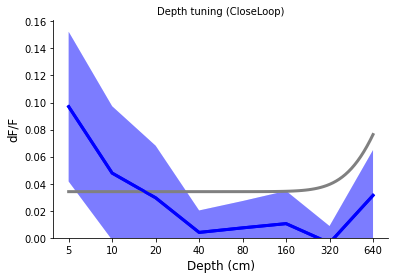

In [97]:
fontsize_dict = {
    'title': 10,
    'xlabel': 12,
    'ylabel': 12,
    'xticks': 10,
    'yticks': 10,
    'legend': 5
}
plot_depth_tuning_curve(dffs=dffs_ast_all, 
                        speeds=speeds, 
                        roi=2, 
                        speed_thr_cal=speed_thr_cal, 
                        depth_list=depth_list, 
                        stim_dict=stim_dict_all, 
                        depth_neurons=depth_neurons, 
                        gaussian_depth=gaussian_depth_fit_df, 
                        fontsize_dict=fontsize_dict, 
                        this_depth=None, 
                        ylim=None, 
                        frame_rate=frame_rate)

In [76]:
save_prefix = "plane0/plots/depth_selectivity/"
if not os.path.exists(session_analysis_folder/save_prefix):
    os.makedirs(session_analysis_folder/save_prefix)

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
session_analysis_folder/save_prefix


/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PosixPath('/camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_foodres_20220101/PZAH8.2f/Analysis/S20230213/SpheresPermTubeRewardPlayback/plane0/plots/depth_selectivity')

In [100]:
manual_choose_rois = True
manually_chosen_rois = [0,1,2]
protocol = protocols[0]
session_analysis_folder_original = root/project/mouse/'Analysis'/session/protocol
# Fit depth tuning curve
for protocol in protocols:
    print(f'---------Fit gaussian depth tuning for protocol {protocol}/{len(protocols)}---------', flush=True)
    # ----- STEP1: Generate file path -----
    flexilims_session = flz.get_flexilims_session(project_id=project)
    all_protocol_recording_entries = get_all_recording_entries(project, mouse, session, protocol=protocol, flexilims_session=flexilims_session)

    # make folder for this protocol (closedloop/playback)
    root = Path(flz.PARAMETERS["data_root"]["processed"])
    session_protocol_folder = root/project/mouse/session/protocol
    session_analysis_folder = root/project/mouse/'Analysis'/session/protocol
        
    with open(session_protocol_folder/"plane0/img_VS_all.pickle", "rb") as handle:
        img_VS_all = pickle.load(handle)
    with open(session_protocol_folder/"plane0/stim_dict_all.pickle", "rb") as handle:
        stim_dict_all = pickle.load(handle)
    dffs_ast_all = np.load(session_protocol_folder/"plane0/dffs_ast_all.npy")
    
    depth_neuron = np.load(session_analysis_folder_original/"plane0/depth_neurons.npy")
    max_depths= np.load(session_analysis_folder_original/"plane0/max_depths_index.npy")
        
    print('---START STEP 6---', '\n', 'Fit gaussian depth tuning...', flush=True)
    print('MIN SIGMA', str(MIN_SIGMA), flush=True)
    batch_num = 5
    depth_min = 2
    depth_max = 2000
    gaussian_depth_fit_df = pd.DataFrame(columns=['ROI', 'preferred_depth_idx', 'a', 'x0_logged', 'log_sigma', 'b','r_sq'])
    gaussian_depth_fit_df.ROI = depth_neurons
    gaussian_depth_fit_df.preferred_depth_idx = max_depths_index
    speeds = img_VS_all.MouseZ.diff() / img_VS_all.HarpTime.diff()  # m/s
    speeds[0] = 0
    # speed_thr = 0.01
    # speeds_thred = thr(speeds, speed_thr)
    speed_arr, _ = create_speed_arr(
        speeds=speeds,
        depth_list=depth_list,
        stim_dict=stim_dict_all,
        mode="sort_by_depth",
        protocol="fix_length",
        blank_period=0,
        frame_rate=frame_rate,
    )

    for iroi, choose_roi in enumerate(depth_neurons):
        roi = choose_roi
        trace_arr, _ = create_trace_arr_per_roi(
            which_roi=roi,
            dffs=dffs_ast_all,
            depth_list=depth_list,
            stim_dict=stim_dict_all,
            mode="sort_by_depth",
            protocol="fix_length",
            blank_period=0,
            frame_rate=frame_rate,
        )
        (ndepths, ntrials, nframes) = trace_arr.shape
        trace_arr[speed_arr < speed_thr_cal] = np.nan
        trace_arr_mean_eachtrial = np.nanmean(trace_arr, axis=2)

        # When open loop, there will be nan values in this array because of low running speed sometimes
        trace_arr_mean_eachtrial = np.nan_to_num(trace_arr_mean_eachtrial)
        x = np.log(np.repeat(np.array(depth_list) * 100, trace_arr_mean_eachtrial.shape[1]))
        roi_number = np.where(depth_neurons == roi)[0][0]
        popt_arr = []
        r_sq_arr = []
        for ibatch in range(batch_num):
            np.random.seed(ibatch)
            p0 = np.concatenate((np.abs(np.random.normal(size=1)),
                                    np.atleast_1d(np.log(np.array(depth_list[int(max_depths[roi_number])]) * 100)),
                                    np.abs(np.random.normal(size=1)),
                                    np.random.normal(size=1))).flatten()
            popt, pcov = curve_fit(gaussian_func, x, trace_arr_mean_eachtrial.flatten(),
                                    p0=p0, maxfev=100000,
                                    bounds=(
                                    [0, np.log(depth_min), 0, -np.inf], [np.inf, np.log(depth_max), np.inf, np.inf]))

            y_pred = gaussian_func(x, *popt)
            r_sq = calculate_R_squared(trace_arr_mean_eachtrial.flatten(), y_pred)
            popt_arr.append(popt)
            r_sq_arr.append(r_sq)
        idx_best = np.argmax(r_sq_arr)
        popt_best = popt_arr[idx_best]
        rsq_best = r_sq_arr[idx_best]

        gaussian_depth_fit_df.iloc[iroi, 2:-1] = popt_best
        gaussian_depth_fit_df.iloc[iroi, -1] = rsq_best

        if iroi % 10 == 0:
            print(roi, flush=True)

    save_filename = session_analysis_folder/('plane0/gaussian_depth_tuning_fit_new_'+str(MIN_SIGMA)+'.pickle')
    with open(save_filename, 'wb') as handle:
        pickle.dump(gaussian_depth_fit_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('---STEP 6 FINISHED.---', '\n', flush=True)
    
    print('---Start plotting.---', '\n', flush=True)
    save_prefix = 'plane0/plots/gaussian_depth_tuning_fit_new_'+str(MIN_SIGMA)+'/'
    if not os.path.exists(session_analysis_folder/save_prefix):
        os.makedirs(session_analysis_folder/save_prefix)
    with open(session_analysis_folder/('plane0/gaussian_depth_tuning_fit_new_'+str(MIN_SIGMA)+'.pickle'), 'rb') as handle:
        gaussian_depth_fit_df = pickle.load(handle)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        if manual_choose_rois:
            select_rois = manually_chosen_rois
            for choose_roi in select_rois:
                roi = choose_roi
                trace_arr_noblank, _ = create_trace_arr_per_roi(
                    which_roi=roi,
                    dffs=dffs_ast_all,
                    depth_list=depth_list,
                    stim_dict=stim_dict_all,
                    mode="sort_by_depth",
                    protocol="fix_length",
                    blank_period=0,
                    frame_rate=frame_rate,
                )
                trace_arr_noblank[speed_arr < speed_thr_cal] = np.nan

                plt.figure(figsize=(5, 5))
                popt = gaussian_depth_fit_df[gaussian_depth_fit_df.ROI==roi].values[0][2:-1]
                r_sq = gaussian_depth_fit_df[gaussian_depth_fit_df.ROI==roi].values[0][-1]
                plot_depth_tuning_curve(dffs=dffs_ast_all, 
                                        speeds=speeds, 
                                        roi=roi, 
                                        speed_thr_cal=speed_thr_cal, 
                                        depth_list=depth_list, 
                                        stim_dict=stim_dict_all, 
                                        depth_neurons=depth_neurons, 
                                        gaussian_depth=gaussian_depth_fit_df, 
                                        fontsize_dict=fontsize_dict, 
                                        this_depth=None, 
                                        ylim=None, 
                                        frame_rate=frame_rate)

                if not os.path.exists(session_analysis_folder/save_prefix/'examples/'):
                    os.makedirs(session_analysis_folder/save_prefix/'examples/')

                plt.savefig(session_analysis_folder/save_prefix/('examples/roi' + str(choose_roi) + '.pdf'))
                print('ROI' + str(choose_roi), flush=True)

        else:
            for this_depth in range(len(depth_list)):

                if not os.path.exists(
                        session_analysis_folder/save_prefix/('depth'+str(depth_list[this_depth]))):
                    os.makedirs(session_analysis_folder/save_prefix/('depth'+str(depth_list[this_depth])))
                save_folder = session_analysis_folder/save_prefix /('depth' + str(depth_list[this_depth]))
                if 'Playback' in protocol:
                    neurons_this_depth = depth_neurons[max_depths == this_depth]
                else:
                    neurons_this_depth = depth_neurons[max_depths == this_depth]
                if len(neurons_this_depth) > 0:
                    rois_mins, rois_maxs = segment_arr(np.arange(len(neurons_this_depth)), segment_size=10)
                    for rois_min, rois_max in zip(rois_mins, rois_maxs):
                        if rois_min != rois_max:
                            select_rois = np.array(neurons_this_depth[rois_min:rois_max])
                        else:
                            select_rois = np.array(neurons_this_depth[rois_min:rois_max + 1])

                        if len(select_rois) > 1:
                            pdf_name = save_folder/('roi' + str(select_rois[0]) + '-' + str(
                                select_rois[-1]) + '.pdf')
                        elif len(select_rois) == 1:
                            pdf_name = save_folder /('roi' + str(select_rois) + '.pdf')
                        with PdfPages(pdf_name) as pdf:

                            for choose_roi in select_rois:

                                roi = choose_roi
                                trace_arr_noblank, _ = create_trace_arr_per_roi(
                                    which_roi=roi,
                                    dffs=dffs_ast_all,
                                    depth_list=depth_list,
                                    stim_dict=stim_dict_all,
                                    mode="sort_by_depth",
                                    protocol="fix_length",
                                    blank_period=0,
                                    frame_rate=frame_rate,
                                )
                                trace_arr_noblank[speed_arr < speed_thr_cal] = np.nan

                                plt.figure(figsize=(5, 5))
                                popt = gaussian_depth_fit_df[gaussian_depth_fit_df.ROI == roi].values[0][2:-1]
                                r_sq = gaussian_depth_fit_df[gaussian_depth_fit_df.ROI == roi].values[0][-1]
                                plot_depth_tuning_curve(dffs=dffs_ast_all, 
                                                        speeds=speeds, 
                                                        roi=roi, 
                                                        speed_thr_cal=speed_thr_cal, 
                                                        depth_list=depth_list, 
                                                        stim_dict=stim_dict_all, 
                                                        depth_neurons=depth_neurons, 
                                                        gaussian_depth=gaussian_depth_fit_df, 
                                                        fontsize_dict=fontsize_dict, 
                                                        this_depth=None, 
                                                        ylim=None, 
                                                        frame_rate=frame_rate)

                                pdf.savefig()
                                plt.close()

                                print('ROI' + str(choose_roi), flush=True)

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---------Fit gaussian depth tuning for protocol SpheresPermTubeReward/2---------
---START STEP 6--- 
 Fit gaussian depth tuning...
MIN SIGMA 0.5


ValueError: cannot convert float NaN to integer

In [103]:
max_depths= np.load(session_analysis_folder_original/"plane0/max_depths_index.npy")

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
max_depths


/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([nan, nan,  5., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan])